In [1]:
from sliderule import sliderule, earthdata, h5, raster, icesat2, gedi
import geopandas as gpd
import dask_geopandas

/srv/conda/envs/notebook/lib/python3.10/site-packages/sliderule/sliderule.py:41: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas


In [2]:
sliderule.init(verbose=False)

In [3]:

region = sliderule.toregion('alaska_north_slope_permafrost_test.geojson')
region = sliderule.toregion('north_slope_smaller.geojson')

# Build ATL06 Request Parameters
parms = {
    "poly": region["poly"],
    "srt": icesat2.SRT_LAND,
    "cnf": icesat2.CNF_SURFACE_HIGH,
    "ats": 7.0,
    "cnt": 10,
    "len": 40.0,
    "res": 20.0,
    
}

# Make ATL06 Request
atl06 = icesat2.atl06p(parms)

In [4]:
atl06.shape

(392282, 15)

In [5]:
#atl06.reset_index(inplace=True)
#atl06_dask = dask_geopandas.from_geopandas(atl06, npartitions=4)

In [5]:
# limit to 2019 and 2020 for now
dt_min = '2019-01-01'
dt_max = '2020-12-31'
mask = (atl06.index>=dt_min) & (atl06.index<=dt_max)
atl06[mask].shape

(212301, 15)

In [6]:
atl06 = atl06[mask]

In [7]:
atl06 = atl06.to_crs('EPSG:32604')

In [8]:
# From DES's crossover notebook
atl06_r = 7
atl06_poly_geom = atl06.geometry.buffer(atl06_r)
atl06_poly = gpd.GeoDataFrame(atl06.copy(), geometry=atl06_poly_geom)
#gedi_gdf_poly_ll = gedi_gdf_poly.to_crs('EPSG:4326')
atl06_poly.shape

(212301, 15)

In [10]:
atl06_poly.keys()

Index(['segment_id', 'dh_fit_dx', 'rms_misfit', 'gt', 'h_mean',
       'w_surface_window_final', 'n_fit_photons', 'rgt', 'spot', 'h_sigma',
       'cycle', 'pflags', 'distance', 'dh_fit_dy', 'geometry'],
      dtype='object')

In [11]:
atl06_xover = gpd.sjoin(atl06_poly[['h_mean', 'segment_id', 'rgt', 'geometry']],
                            atl06_poly[['h_mean', 'segment_id', 'rgt', 'geometry']])

In [12]:
atl06_xover['height_change'] = atl06_xover['h_mean_left'] - atl06_xover['h_mean_right']

<AxesSubplot: >

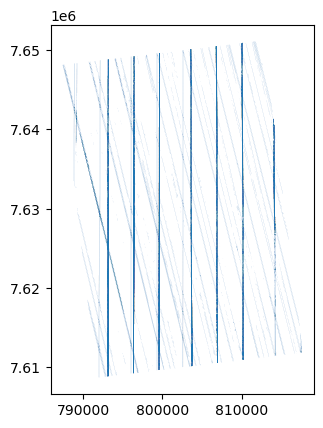

In [13]:
atl06_xover.plot()

In [36]:
def xover_proc(df):
    #Convert back to point geometry
    df['geometry'] = df.centroid.geometry
    df['dt_diff'] = df.index - df['index_right']   
    #Remove any self intersections
    idx = (df.index != df['index_right'])
    df = df.loc[idx]
    #Remove repeat intersections
    idx_date_repeat = (df.index>df['index_right'])
    return df.loc[idx_date_repeat]

In [37]:
atl06_xover = xover_proc(atl06_xover)

In [38]:
atl06_xover.shape

(173096, 10)

<AxesSubplot: >

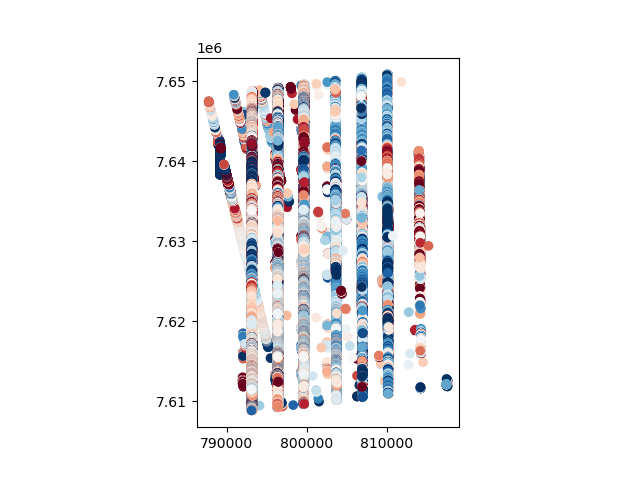

In [39]:
atl06_xover.plot(column='height_change',cmap='RdBu',vmin=-1,vmax=1)

In [19]:
atl06_xover.describe()

,h_mean_left,segment_id_left,rgt_left,h_mean_right,segment_id_right,rgt_right,height_change,dt_diff
count,346192.000000,346192.000000,346192.000000,346192.000000,346192.000000,346192.000000,3.461920e+05,346192
mean,602.475500,610661.924233,963.486785,602.475500,610661.924233,963.486785,9.194988e-18,0 days 00:00:00
std,115.640771,46369.334863,269.167238,115.640771,46369.334863,269.167238,1.480259e+01,282 days 07:15:12.122037792
min,262.372929,380744.000000,7.000000,262.372929,380744.000000,7.000000,-5.858862e+02,-673 days +20:47:32.504972800
25%,515.813650,619551.000000,838.000000,515.813650,619551.000000,838.000000,-3.085608e-01,-182 days +08:40:19.537114368
50%,600.146098,620032.000000,838.000000,600.146098,620032.000000,838.000000,0.000000e+00,0 days 00:00:00
75%,672.624073,620505.000000,1280.000000,672.624073,620505.000000,1280.000000,3.085608e-01,181 days 15:19:40.462885632
max,1286.851490,621012.000000,1280.000000,1286.851490,621012.000000,1280.000000,5.858862e+02,672 days 03:12:27.495027200


In [22]:
! pip install contextily

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 kB 2.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 856.6 kB/s eta 0:00:00a 0:00:01


In [ ]:
atl06

In [26]:
import contextily as ctx
import matplotlib.pyplot as plt

In [28]:
atl06_xover.crs

<Projected CRS: EPSG:32604>
Name: WGS 84 / UTM zone 4N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 162°W and 156°W, northern hemisphere between equator and 84°N, onshore and offshore. United States (USA) - Alaska (AK).
- bounds: (-162.0, 0.0, -156.0, 84.0)
Coordinate Operation:
- name: UTM zone 4N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [31]:
%matplotlib widget

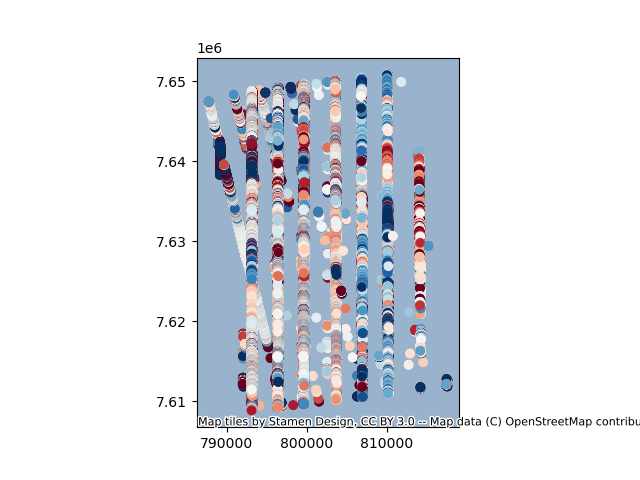

In [32]:
f,ax = plt.subplots()

atl06_xover.plot(column='height_change',cmap='RdBu',vmin=-1,vmax=1,ax=ax)
ctx.add_basemap(ax=ax,attribution=None)

In [40]:
atl06_xover.head()

,h_mean_left,segment_id_left,rgt_left,geometry,index_right,h_mean_right,segment_id_right,rgt_right,height_change,dt_diff
time,,,,,,,,,,
2020-02-27 01:26:27.366688000,452.203143,382644,952,POINT (792196.145 7645946.583),2019-01-23 09:13:24.741764096,452.827594,619090,396,-0.624451,399 days 16:13:02.624923904
2020-02-27 01:26:27.363887360,452.903459,382643,952,POINT (792200.901 7645927.128),2019-01-23 09:13:24.744609536,453.267961,619091,396,-0.364502,399 days 16:13:02.619277824
2020-02-27 01:26:27.361026048,453.569360,382642,952,POINT (792205.764 7645907.227),2019-01-23 09:13:24.747451392,453.678581,619092,396,-0.109221,399 days 16:13:02.613574656
2020-02-27 01:26:27.358290688,454.159758,382641,952,POINT (792210.411 7645888.216),2019-01-23 09:13:24.750291456,453.997061,619093,396,0.162697,399 days 16:13:02.607999232
2020-02-27 01:26:27.355490560,454.724240,382640,952,POINT (792215.196 7645868.768),2019-01-23 09:13:24.753122048,454.203305,619094,396,0.520935,399 days 16:13:02.602368512


In [41]:
atl06_xover.explore()

TypeError: Object of type Timedelta is not JSON serializable

In [45]:
#from datetime explore issue on folium
import folium
import pandas as pd
def explore(gdf: gpd.GeoDataFrame, *args, column=None, **kwargs) -> folium.Map:
    """Version of `GeoDataFrame.explore()` method that handles columns of 
    DateTime64 somewhat reasonably. All arguments are passed on to `.explore()` after
    handling DateTime64 columns in `gdf` or `column`.
    
    Can be used in a pipe like so: 
        gdf.pipe(explore, m=m, column="datetime64_col", name="time")"""

    dt_columns = gdf.select_dtypes(["datetime64", "timedelta64"]).columns

    if isinstance(column, str):
        column = gdf[column]
    if pd.api.types.is_datetime64_any_dtype(column):
        column = column.astype("int64")
        # this keeps the branca from encountering an overflow in long_scalars
        column = column-column.min() 
        column = column / column.max() 
    
    gdf = gdf[:]
    gdf[dt_columns] = gdf[dt_columns].astype("str")
    return gdf.explore(*args, column=column, **kwargs)

In [46]:
atl06_xover.pipe(explore)

TypeError: Object of type Timestamp is not JSON serializable

## Figure out why are the tracks actually repeat track where the lines are continous, and which ones which are crossovers

#### The lower block is using 

#### The lower block is using dask_geopandas, first we try to use geopandas only



In [10]:
atl06_dask = dask_geopandas.from_geopandas(atl06_poly, npartitions=4)

In [ ]:
atl06_xover = dask_geopandas..overlaps(atl06_poly[['h_mean', 'segment_id', 'rgt', 'geometry', 'time']],
                            atl06_poly[['h_mean', 'segment_id', 'rgt', 'geometry', 'time']],
                            how='intersection')

In [12]:
atl06_xover = atl06_dask.loc[:,['h_mean', 'segment_id', 'rgt', 'geometry']].sjoin(
    atl06_dask.loc[:,['h_mean', 'segment_id', 'rgt', 'geometry']])

In [14]:
atl06_xover_answer = atl06_xover.compute()

In [16]:
atl06_xover_answer.shape

(453228, 8)

In [17]:
# seperate repatitive points next

In [ ]:
#Compute difference in elevation and time
atl06_xover['h_te_diff'] = atl06_xover['h_mean_left'] - atl08_xover['h_mean_right']
#atl06_xover['h_canopy_diff'] = atl06_xover['h_mean_left'] - atl08_xover['h_mean_right']